In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')

%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/'
results_path = '/content/drive/My Drive/DeepLearning_2021/FinalProject/Results/'

import os
for dirname, _, filenames in os.walk(data_path):
    for i, filename in enumerate(filenames):
            print(os.path.join(dirname,filename))
            


Mounted at /content/drive
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/bme.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/fcc.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/enags.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/naturgy-energy.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/atresmedia.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/acerinox.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/siemens-gamesa.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/sacyr.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/banco-sabadell.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/acs.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/acciona.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/santander.csv
/content/drive/My Drive/DeepLearning_2021/FinalProject/archive/

# Load Data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv(data_path+"/{}.csv".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

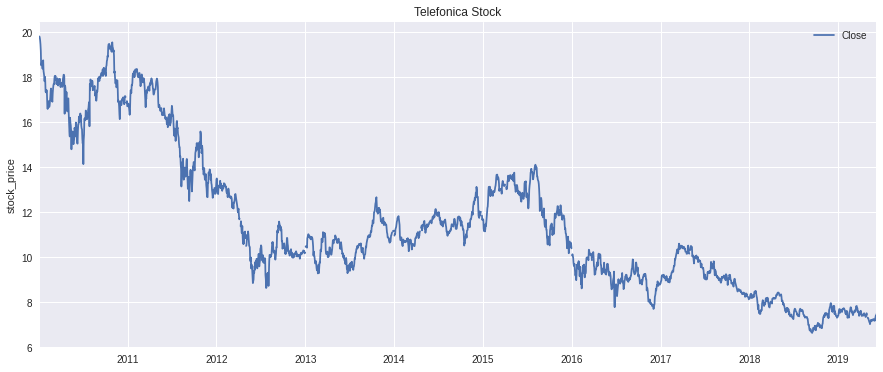

In [3]:
dates = pd.date_range('2010-01-04','2019-06-07',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv(data_path+"/telefnica.csv", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("Telefonica Stock")
plt.show()

In [4]:
df_ibm=df_ibm[['Close']]
df_ibm.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460 entries, 2010-01-04 to 2019-06-07
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2412 non-null   float64
dtypes: float64(1)
memory usage: 118.4 KB


In [5]:
df_ibm=df_ibm.fillna(method='ffill') #fill the null entries

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm


In [6]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);

    test_set_size = int(np.round(0.2*data.shape[0])); #20% of test data
    train_set_size = data.shape[0] - (test_set_size); #80% of train data

    #split the data into train and test. 
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1920, 59, 1)
y_train.shape =  (1920, 1)
x_test.shape =  (480, 59, 1)
y_test.shape =  (480, 1)


In [7]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
y_train.size(),x_train.size()

(torch.Size([1920, 1]), torch.Size([1920, 59, 1]))

# Build the structure of model

In [9]:
# Build model
#####################
#We experiment with number of hidden layers and num layers
input_dim = 1
hidden_dim = 48
num_layers = 3
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 48, num_layers=3, batch_first=True)
  (fc): Linear(in_features=48, out_features=1, bias=True)
)
14
torch.Size([192, 1])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 48])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([192, 48])
torch.Size([192, 48])
torch.Size([192])
torch.Size([192])
torch.Size([1, 48])
torch.Size([1])


In [10]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.030713267624378204
Epoch  20 MSE:  0.02572527341544628
Epoch  30 MSE:  0.005988880060613155
Epoch  40 MSE:  0.0035297381691634655
Epoch  50 MSE:  0.0028316588141024113
Epoch  60 MSE:  0.002503759926185012
Epoch  70 MSE:  0.0022823528852313757
Epoch  80 MSE:  0.002139948308467865
Epoch  90 MSE:  0.0020173618104308844
Epoch  100 MSE:  0.001938661909662187
Epoch  110 MSE:  0.0018774011405184865
Epoch  120 MSE:  0.0018232973525300622
Epoch  130 MSE:  0.0017718784511089325
Epoch  140 MSE:  0.001721915090456605
Epoch  150 MSE:  0.0016722572036087513
Epoch  160 MSE:  0.0016221863916143775
Epoch  170 MSE:  0.0015710486331954598
Epoch  180 MSE:  0.0015180525369942188
Epoch  190 MSE:  0.0014623660827055573


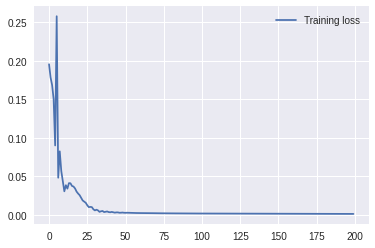

In [11]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [12]:
np.shape(y_train_pred)

torch.Size([1920, 1])

In [13]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.25 RMSE
Test Score: 0.18 RMSE


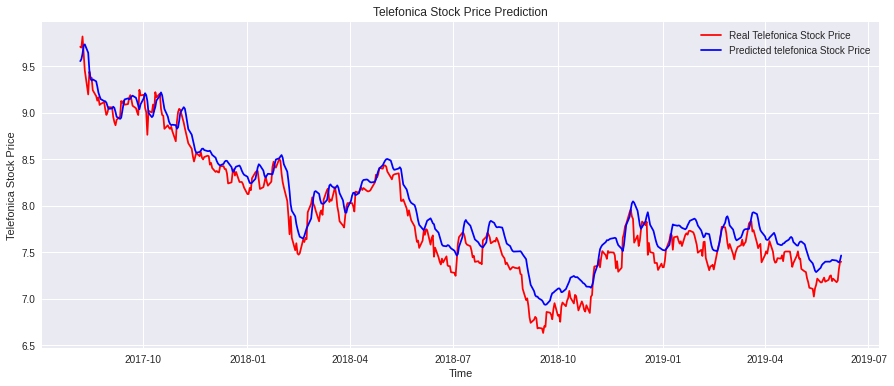

In [14]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real Telefonica Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted telefonica Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Telefonica Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Telefonica Stock Price')
plt.legend()
plt.savefig(results_path+'/telf_pred_ModifiedLSTM.png')
plt.show()